Find eigenvalues of test-data in subspace defined by eigenvector estimates of the training data.

In [1]:
from sklearn import covariance
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import linalg, stats

In [2]:
np.random.seed(1234)

In [3]:
# Simulate some data

ndim = 1_000
nwindow = 300
ntrain = 200
ntest = nwindow - ntrain

n_eigs = 300
n_approx = 30

def transform(samples, vecs, vals):
    return samples + (samples @ vecs.T) @ (vecs * (np.sqrt(vals) - 1)[:, None])


# Generate true eigenvectors that are somewhat sparse
true_eigvecs = np.random.randn(n_eigs, ndim) ** 5
true_eigvecs[...] /= linalg.norm(true_eigvecs, axis=-1)[:, None]
true_eigvecs, _ = linalg.qr(true_eigvecs.T, mode='economic')
true_eigvecs = true_eigvecs.T

# The true eigenvalues of those eigenvectors
#true_eigvals = np.array([10, 5, 0.1]) ** 2
true_eigvals = np.exp(2 * np.random.randn(n_eigs))
true_eigvals.sort()

# Generate data accordingly
window_samples = np.random.randn(nwindow, ndim)
window_samples = transform(window_samples, true_eigvecs, true_eigvals)

window_grads = np.random.randn(nwindow, ndim)
window_grads = transform(window_grads, true_eigvecs, 1 / true_eigvals)

stds = window_samples.std(0)
mean = window_samples.mean(0)
window_samples[...] -= mean[None, :]
window_samples[...] /= stds[None, :]
window_grads[...] *= stds[None, :]

train_samples = window_samples[:ntrain]
test_samples = window_samples[ntrain:]

train_grads = window_grads[:ntrain]
test_grads = window_grads[ntrain:]

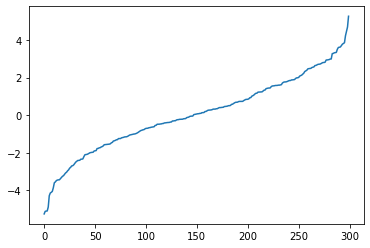

In [4]:
plt.plot(np.log(true_eigvals))  # Plus ndim - n_eigs times 1

In [5]:
def coveigs_lw(samples, grads, n_eigs):
    """Return eigenvalue and eigenvector estimates.
    
    A real implementation should not store the matrix
    for large n.
    """
    eigvals = []
    eigvecs = []
    
    cov_samples, _ = covariance.ledoit_wolf(samples)
    S, V = linalg.eigh(cov_samples)
    eigvals.extend(S[::-1][:n_eigs // 2])
    eigvecs.extend(V.T[::-1][:n_eigs // 2])
    
    cov_grads, _ = covariance.ledoit_wolf(grads)
    S, V = linalg.eigh(cov_grads)
    eigvals.extend(1 / S[::-1][:n_eigs // 2])
    eigvecs.extend(V.T[::-1][:n_eigs // 2])
    
    return eigvals, eigvecs

In [6]:
# Use the train data to get (not necessarily orthogonal)
# estimates for the eigenvectors and eigenvalues.
vals, vecs = coveigs_lw(train_samples, train_grads, n_approx)
vals

[24.85558186311649,
 19.55951023256052,
 16.526173332304168,
 14.610424336632477,
 11.457608514034783,
 11.096850022203252,
 10.250475943575722,
 9.848575880940512,
 9.531650974375772,
 9.303444431124746,
 8.851382577867072,
 8.330312361201791,
 8.126213640178975,
 7.613188265027465,
 7.100485816435422,
 0.0032239062024630857,
 0.003801400241513616,
 0.004163330626530426,
 0.005001471683562453,
 0.0053034702290067695,
 0.007720532120343102,
 0.00844242149759962,
 0.009603762117668582,
 0.010801044507738397,
 0.012308541584426033,
 0.01242754715822388,
 0.0136865053946702,
 0.014407209993533975,
 0.014904209921506083,
 0.0160885042111894]

In [7]:
# Filter out eigenvalues close to 1.
# After this step we do not use the eigenvalues anymore,
# but only the eigenvectors
vals, vecs = zip(*
    (
        (val, vec) for val, vec in zip(vals, vecs)
        if np.abs(np.log(val)) > 0.4
    )
)
vals = np.array(vals)
vecs = np.array(vecs)

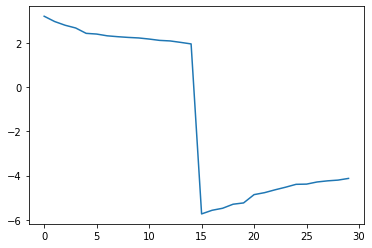

In [8]:
plt.plot(np.log(vals))

In [9]:
# Find a orthogonal basis for the subspace spanned
# by the eigenvectors.
_, S, V = linalg.svd(vecs, full_matrices=False)
vecs = V[S > 0.95]
vals = vals[S > 0.95]

In [10]:
# Project the test samples into this space
projected_test_samples = test_samples @ vecs.T

In [11]:
projected_test_samples.shape  # (n_samples, n_dims)

(100, 30)

In [12]:
# Find the eigenvalues and eigenvectors of the test
# samples in this low-dimensional space.
_, svd, inner_eigvals = linalg.svd(projected_test_samples, full_matrices=False)
test_eigvals = svd ** 2 / ntest

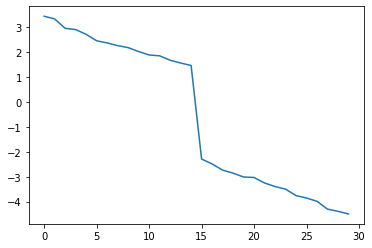

In [13]:
plt.plot(np.log(test_eigvals))

In [14]:
# Project the eigenvalues in the small space back to the
# original space.
test_eigvecs = inner_eigvals @ vecs

In [15]:
# Filter out eigenvalues close to 1
test_eigvals, test_eigvecs = zip(*(
    (val, vec) for val, vec in zip(test_eigvals, test_eigvecs)
    if np.abs(np.log(val)) > 0.4)
)

In [16]:
test_eigvals = np.array(test_eigvals)
test_eigvecs = np.array(test_eigvecs)

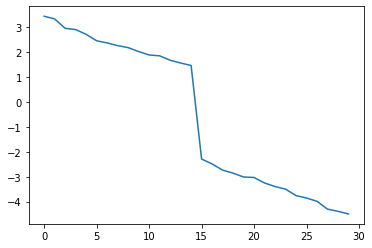

In [17]:
plt.plot(np.log(test_eigvals))

Now we can use test_eigvals and test_eigvecs for sampling

#### Compare different mass matrix approximations

In [18]:
# The true posterior covariance
true_cov = np.eye(ndim) + true_eigvecs.T @ np.diag(true_eigvals - 1) @ true_eigvecs
diag = np.diag(true_cov)
true_corr = true_cov.copy()
true_corr[...] /= np.sqrt(diag)[None, :]
true_corr[...] /= np.sqrt(diag)[:, None]

# The covariance we estimated with the eigenvectors above
approx_cov = np.eye(ndim) + test_eigvecs.T @ np.diag(test_eigvals - 1) @ test_eigvecs
approx_cov[...] *= stds[None, :]
approx_cov[...] *= stds[:, None]

In [19]:
# A ledoit wolf covariance estimate of _all_ samples in the window
cov_lw, _ = covariance.ledoit_wolf(window_samples)
cov_lw[...] *= stds[None, :]
cov_lw[...] *= stds[:, None]

In [20]:
def condition_number(cov, true_cov):
    eigs = linalg.eigvalsh(true_cov, cov)
    return np.sqrt(np.max(eigs) / np.min(eigs))

In [21]:
print(condition_number(np.eye(ndim), true_cov))
print(condition_number(np.diag(stds ** 2), true_cov))
print(condition_number(cov_lw, true_cov))
print(condition_number(approx_cov, true_cov))

191.46394040754484
109.2453105957265
35.638029922273596
29.38728137984108


What eigenvalues are left in the posterior if we use a particular mass matrix?

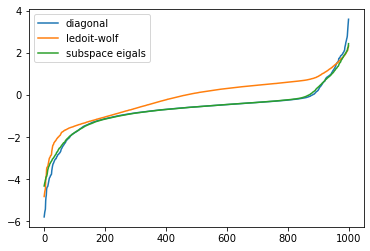

In [22]:
plt.plot(np.log(linalg.eigvalsh(true_cov, np.diag(stds ** 2))), label='diagonal')
plt.plot(np.log(linalg.eigvalsh(true_cov, cov_lw)), label='ledoit-wolf')
plt.plot(np.log(linalg.eigvalsh(true_cov, approx_cov)), label='subspace eigals')
plt.legend();